In [ ]:
!pip install sklearn_evaluation

In [3]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, make_scorer
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn_evaluation import plot
from sklearn.model_selection import GridSearchCV
from sklearn_evaluation.plot import grid_search

In [4]:
df = pd.read_csv("/content/diabetes.csv")
df.head()

,Unnamed: 0,Diabetes_binary,HighBP,High Cholesterol,Cholesterol Check,BMI,Smoker,Stroke,HeartDiseaseorAttack,Physical Activity,...,Any Health Care,No Doctor because of Cost,General Health,Mental Health,Physical Health,Difficulty Walking,Sex,Age,Education,Income
0,0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,...,1.0,0.0,Medium,5.0,30.0,0.0,male,4.0,Cat6,Cat8
1,1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,...,1.0,0.0,Medium,0.0,0.0,0.0,male,12.0,Cat6,Cat8
2,2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,...,1.0,0.0,High,0.0,10.0,0.0,male,13.0,Cat6,Cat8
3,3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,...,1.0,0.0,Medium,0.0,3.0,0.0,male,11.0,Cat6,Cat8
4,4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,...,1.0,0.0,Good,0.0,0.0,0.0,female,8.0,Cat5,Cat8


#Preprocessing


1.   Rename column's name
2.   Removing null values / meaningless values
3.   Normalization
4.   Change categorical features to one-hot-encoding
5.   Create train and test dataset 


### Rename columns

In [5]:
# Rename column names
df.columns = df.columns.str.replace(' ','_')

In [7]:
# Check unique values for each column
for col in df:
    print(col,' : ',df[col].unique())

Unnamed:_0  :  [    0     1     2 ... 70689 70690 70691]
Diabetes_binary  :  [0. 1.]
HighBP  :  [1. 0.]
High_Cholesterol  :  [0. 1.]
Cholesterol_Check  :  [1. 0.]
BMI  :  [26. 28. 29. 18. 31. 32. 27. 24. 21. 58. 30. 20. 22. 38. 40. 25. 36. 47.
 19. 37. 41. 23. 34. 35. 42. 17. 33. 44. 15. 52. 69. 56. 45. 39. 92. 53.
 98. 50. 46. 79. 48. 16. 63. 72. 54. 49. 68. 43. 84. 73. 76. 55. 51. 75.
 57. 60. 12. 77. 82. 67. 71. 61. 14. 81. 59. 86. 13. 87. 65. 95. 89. 62.
 64. 66. 85. 70. 83. nan 80. 78. 74.]
Smoker  :  [0. 1.]
Stroke  :  [0. 1.]
HeartDiseaseorAttack  :  [ 0.  1. nan]
Physical_Activity  :  [ 1.  0. nan]
Fruits  :  [ 0.  1. nan]
Veggies  :  [ 1.  0. nan]
Heavy_Alcohol_Consumption  :  [ 0.  1. nan]
Any_Health_Care  :  [ 1.  0. nan]
No_Doctor_because_of_Cost  :  [ 0.  1. nan]
General_Health  :  ['Medium' 'High' 'Good' 'Low' 'Very Low' nan]
Mental_Health  :  [ 5.  0.  7.  3.  4.  2. 30. 20.  1. 15. 10. 25. 14. 28.  6. 29. 26. 12.
 16. 22. 13.  8.  9. 21. 18. 17. 27. nan 24. 23. 11. 19.]

### Removing null / meaningless values


*   Drop "Unnamed:_0" column
*   Drop rows with nan values in binary attributes
*   Replace nan-values with average in "BMI" column
*   Drop 'Unknoun" category for "Income" column (because there was only one row with this value)



In [8]:
# unused columns
df.drop(columns=['Unnamed:_0'], inplace=True)

In [9]:
# drop nan values in columns with binary values
binary_columns = ['Diabetes_binary', 'HighBP', 'High_Cholesterol', 'Cholesterol_Check', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'Physical_Activity', 'Fruits', 'Veggies'
, 'Heavy_Alcohol_Consumption', 'Any_Health_Care', 'No_Doctor_because_of_Cost', 'Difficulty_Walking']
df.dropna(subset=binary_columns, inplace=True)

# replace nan value with average value for BMI
BMI_mean_value = df['BMI'].mean()
df['BMI'].fillna(value=BMI_mean_value, inplace=True)

# drop nan value and 'Unknown' value for BMI
df.dropna(subset=['Income'], inplace=True)
df.drop((df.loc[(df['Income'] == 'Unknown')]).index, inplace=True)

In [10]:
df.isnull().sum()

Diabetes_binary              0
HighBP                       0
High_Cholesterol             0
Cholesterol_Check            0
BMI                          0
Smoker                       0
Stroke                       0
HeartDiseaseorAttack         0
Physical_Activity            0
Fruits                       0
Veggies                      0
Heavy_Alcohol_Consumption    0
Any_Health_Care              0
No_Doctor_because_of_Cost    0
General_Health               0
Mental_Health                0
Physical_Health              0
Difficulty_Walking           0
Sex                          0
Age                          0
Education                    0
Income                       0
dtype: int64

So there is no longer null values in our dataset

###Normalization

In [12]:
# Normalize columns with scalar values
scaler = StandardScaler()
scalar_columns = ['BMI', 'Mental_Health', 'Physical_Health', 'Age']
df[scalar_columns] = scaler.fit_transform(df[scalar_columns])

###Categorical to one-hot-encoding

In [13]:
# Change categorical columns to one-hot-encoding
final_df = pd.get_dummies(df)

### Split train/test data

In [14]:
# seperate data and label
X = final_df.drop("Diabetes_binary", axis=1)
y = final_df['Diabetes_binary']

In [16]:
# split 20% of data for test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

# Classification model

### define model and train

defining XGBClassifier with given parameters in project form

In [17]:
classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.5,
    colsample_bytree=1,
    random_seed=123,
    eval_metric='auc',
    early_stopping_rounds=10,
    verbosity=1
)

classifier.fit(X_train,
               y_train.ravel())

XGBClassifier(early_stopping_rounds=10, eval_metric='auc', max_depth=4,
              n_estimators=200, random_seed=123, subsample=0.5)

### Evaluation: 

*   train and test accuracy
*   train and test precision
*   train and test recal
*   ROC-AUC score
*   confusion matrix



In [19]:
test_pred = classifier.predict(X_test)
train_pred = classifier.predict(X_train)

# Calculating accuracy
test_accuracy = accuracy_score(y_test, test_pred)
train_accuracy = accuracy_score(y_train, train_pred)

print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))

# Calculating precision
test_precision = precision_score(y_test, test_pred, average='weighted')
train_precision = precision_score(y_train, train_pred, average='weighted')

print("Test precision: " , test_precision)
print("Train precision: " , train_precision)

# Calculating recall
test_recall = recall_score(y_test, test_pred, average='weighted')
train__recall = recall_score(y_train, train_pred, average='weighted')

print("Test recall: " , test_recall)
print("Train recall: " , train__recall)

# Calculating ROC-AUC score
print("ROC score: ",roc_auc_score(y, classifier.predict_proba(X)[:, 1])

Test Accuracy: 75.70%
Train Accuracy: 76.13%
Test precision:  0.7590498422915508
Train precision:  0.7632181640824282
Test recall:  0.7570377705474608
Train recall:  0.7613001343990946
ROC score:  0.8408165167760342


[[5040 2029]
 [1406 5663]]


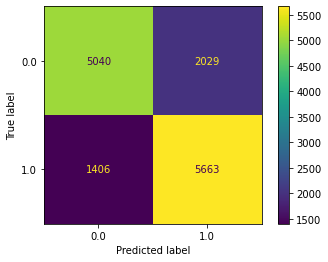

In [20]:
matrix = confusion_matrix(y_test, test_pred)
print(matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classifier.classes_)
disp.plot()
plt.show()

#Hyperparameters tuning

### Finding best hyperparameters for our XGBClassifier using GridSearchCV

In [22]:
def my_roc_auc_score(classifier, X, y):
   return roc_auc_score(y, classifier.predict_proba(X)[:,1])

parameters = {
    "learning_rate":  [0.02, 0.05, 0.1, 0.3],
    "max_depth": [2, 3, 4],
    "n_estimators":  [100, 200, 300],
    "colsample_bytree": [0.8, 1],
}

new_classifier = xgb.XGBClassifier(subsample=0.5,eval_metric='auc')

model = GridSearchCV(new_classifier, parameters, n_jobs=1, cv=3, scoring=my_roc_auc_score)

model.fit(X_train, y_train.ravel())

GridSearchCV(cv=3, estimator=XGBClassifier(eval_metric='auc', subsample=0.5),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.02, 0.05, 0.1, 0.3],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             scoring=<function my_roc_auc_score at 0x7f70de7c9170>)

In [23]:
print("Best hyperparameters: \n", model.best_params_)

Best hyperparameters: 
 {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}


### Evaluation: 

*   train and test accuracy
*   train and test precision
*   train and test recal
*   ROC-AUC score
*   confusion matrix



In [26]:
best_classifier = xgb.XGBClassifier(**model.best_params_)

best_classifier.fit(X_train, y_train.ravel())

best_test_pred = best_classifier.predict(X_test)
best_train_pred = best_classifier.predict(X_train)

best_test_accuracy = accuracy_score(y_test, best_test_pred)
best_train_accuracy = accuracy_score(y_train, best_train_pred)

print("Test Accuracy: %f%%" % (best_test_accuracy * 100.0))
print("Train Accuracy: %f%%" % (best_train_accuracy * 100.0))

test_precision = precision_score(y_test, best_test_pred, average='weighted')
train_precision = precision_score(y_train, best_train_pred, average='weighted')

print("Test precision: " , test_precision)
print("Train precision: " , train_precision)

test_recall = recall_score(y_test, best_test_pred, average='weighted')
train__recall = recall_score(y_train, best_train_pred, average='weighted')

print("Test recall: " , test_recall)
print("Train recall: " , train__recall)

print("ROC score: ",roc_auc_score(y, best_classifier.predict_proba(X)[:, 1]))

Test Accuracy: 75.753289%
Train Accuracy: 75.558817%
Test precision:  0.7592302021266517
Train precision:  0.7572236667581089
Test recall:  0.757532890083463
Train recall:  0.7555881728796774
ROC score:  0.8342108836262025


[[5069 2000]
 [1428 5641]]


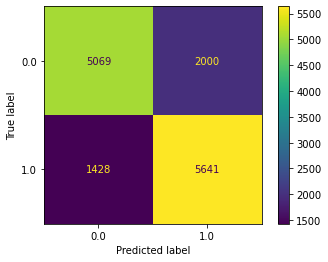

In [27]:
new_matrix = confusion_matrix(y_test, best_test_pred)
print(new_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=new_matrix, display_labels=classifier.classes_)
disp.plot()
plt.show()

# hyperparameter changes plot

In [53]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])

        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

**Plot of mean score and its standard deviation for each parameter**

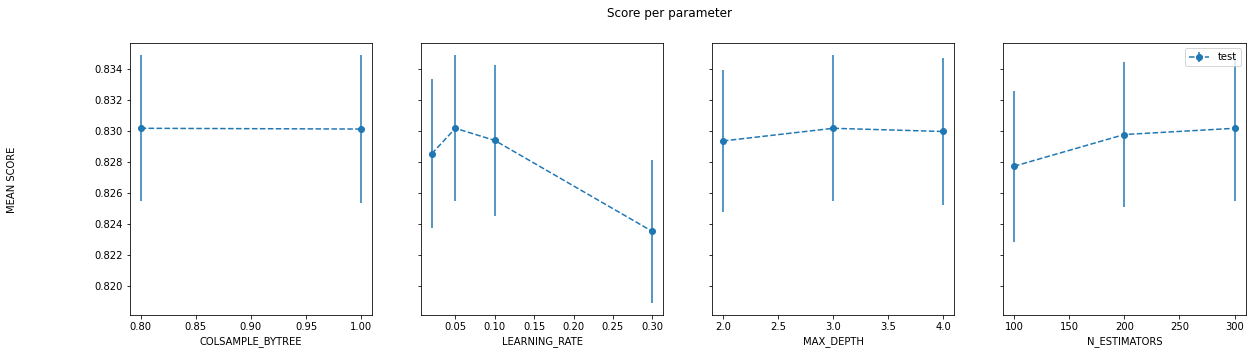

In [54]:
plot_search_results(model)

Mean score for colsample_bytree=0.8 and colsample_bytree=1 according to changes in other three parameters

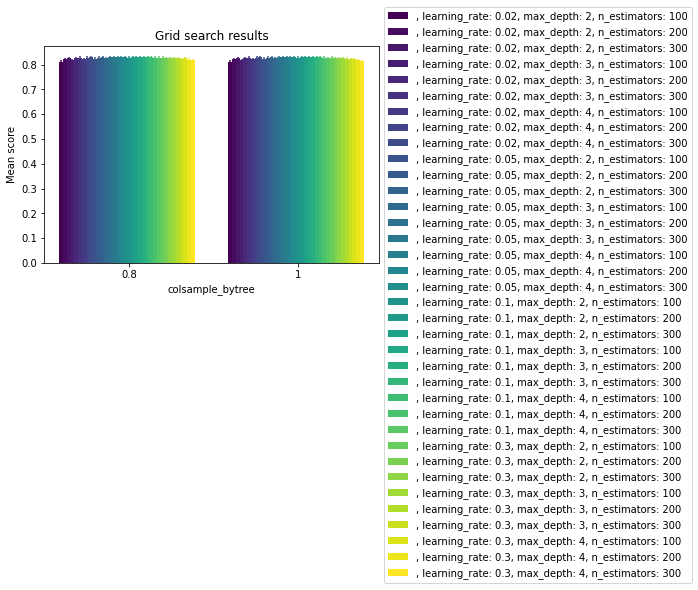

In [43]:
grid_search(model.cv_results_, change='colsample_bytree', kind='bar')
plt.legend(bbox_to_anchor=(1, 1.2))
plt.show()

Mean score for learning_rate=0.02, learning_rate=0.05, learning_rate=0.1 and learning_rate=0.3 according to changes in other three parameters

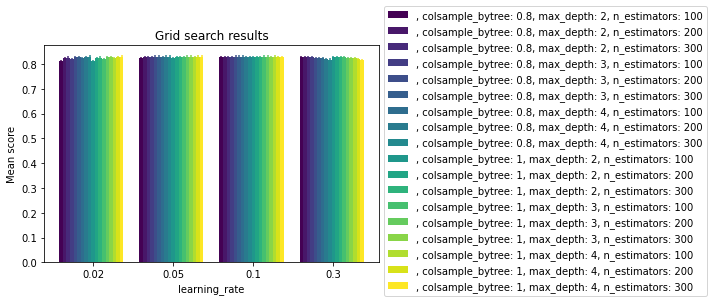

In [36]:
grid_search(model.cv_results_, change='learning_rate', kind='bar')
plt.legend(bbox_to_anchor=(1, 1.2))
plt.show()

Mean score for n_estimators=100, n_estimators=200 and n_estimators=300  according to changes in other three parameters

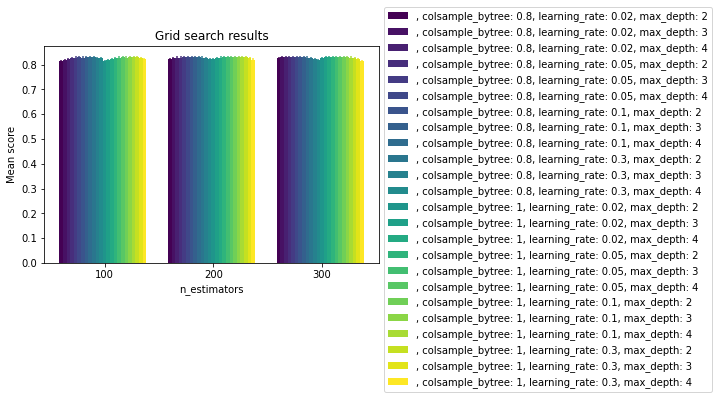

In [37]:
grid_search(model.cv_results_, change='n_estimators', kind='bar')
plt.legend(bbox_to_anchor=(1, 1.2))
plt.show()

Mean score for max_depth=2, max_depth=3 and max_depth=4  according to changes in other three parameters

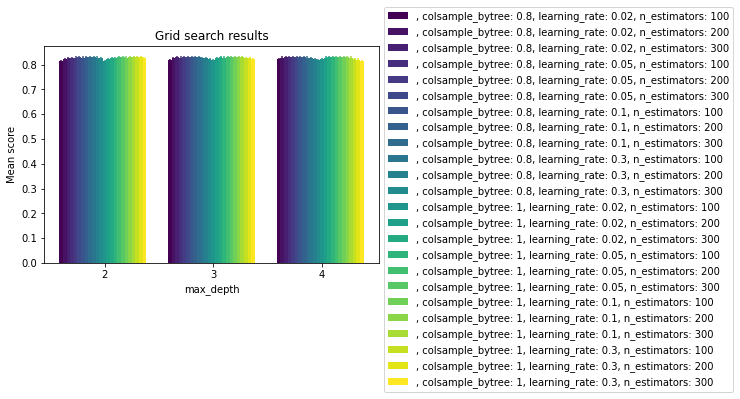

In [38]:
grid_search(model.cv_results_, change='max_depth', kind='bar')
plt.legend(bbox_to_anchor=(1, 1.2))
plt.show()